# Analyze Queueing and Routing Policies

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from utils import *
import numpy as np
import random
# fix random seed for reproducibility
random.seed(0)
np.random.seed(0)

## 1) Load Dataset

In [2]:
from utils import *
import pandas as pd
from pathlib import Path

results_dir = Path('../results') # Define root results directory

stats_files = sorted(results_dir.glob('**/*stats*.csv')) # Find all files containing "stats" and ending with .csv in all subdirectories
raw_files = sorted(results_dir.glob('**/*raw*.csv')) # Find all files containing "raw" and ending with .csv in all subdirectories
print(f"Found {len(stats_files)} stats CSV files and {len(raw_files)} raw CSV files:")

# Load all stats files into a dictionary of dataframes
stats_dfs = {}
for file_path in stats_files:
    try:
        df = pd.read_csv(file_path)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        # Create key: subfolder_name/filename_stem
        relative_path = file_path.relative_to(results_dir)
        key = str(relative_path.parent / relative_path.stem)
        stats_dfs[key] = df
        print(f"✅ {relative_path} -> shape {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")

# Load all raw files into a dictionary of dataframes
raw_dfs = {}
for file_path in raw_files:
    try:
        df = pd.read_csv(file_path)
        # Strip whitespace from column names
        df.columns = df.columns.str.strip()
        # Create key: subfolder_name/filename_stem
        relative_path = file_path.relative_to(results_dir)
        key = str(relative_path.parent / relative_path.stem)
        raw_dfs[key] = df
        print(f"✅ {relative_path} -> shape {df.shape}")
    except Exception as e:
        print(f"❌ Error loading {file_path.name}: {e}")

print(f"\n✅ Loaded {len(stats_dfs)} stats dataframes and {len(raw_dfs)} raw dataframes ✅")

Found 27 stats CSV files and 27 raw CSV files:
✅ cloud/cloud_stats_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_google-gemini-2-5-flash-always_cloud_once_per_sec_2025-12-05T10-00-00.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_google-gemma-3n-e4b-it_always_cloud_once-per-sec_2025-12-05T08-07-39.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_meta-llama-llama-3-2-3b-instruct_always_cloud_once-per-sec_2025-12-05T07-31-00.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02.csv -> shape (3, 7)
✅ cloud/cloud_stats_experiment_qwen-qwen3-8b_always_cloud_once-per-sec_2025-12-05T0

In [3]:
# Check the keys in raw_dfs
print("Available keys in raw_dfs:")
for key in raw_dfs.keys():
    print(key)

Available keys in raw_dfs:
cloud/cloud_raw_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38
cloud/cloud_raw_experiment_google-gemini-2-5-flash-always_cloud_once_per_sec_2025-12-05T10-00-00
cloud/cloud_raw_experiment_google-gemma-3n-e4b-it_always_cloud_once-per-sec_2025-12-05T08-07-39
cloud/cloud_raw_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33
cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54
cloud/cloud_raw_experiment_meta-llama-llama-3-2-3b-instruct_always_cloud_once-per-sec_2025-12-05T07-31-00
cloud/cloud_raw_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02
cloud/cloud_raw_experiment_qwen-qwen3-8b_always_cloud_once-per-sec_2025-12-05T07-52-16
fabian/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-03T20-58-00
fabian/raw_experiment_Qwen3-4B-ONNX_always_device_once-per-sec_2025-12-06T10-14-33
fabia

## Coming up with a routing policy
We want to find out the optimal Threshold T here for our "smart" scheduling policy. On the hardware we tested, mostly the cloud based inference was faster than on-device. We expect that in the future models will get faster and more people will have more access to higher performance hardware in their devices, thats why we lower the inference time for the on-device models by multiplying it with a `on_device_speedup_factor` and performing a linear shift with `on_device_speedup_shift`.

In [4]:
from utils import *

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_meta-llama-llama-3-2-1b-instruct_always_cloud_once-per-sec_2025-12-04T16-10-54'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_Llama-3-2-1B-Instruct-ONNX_always_device_once-per-sec_2025-12-04T08-10-53'].copy()

#df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_ibm-granite-granite-4-0-h-micro_always_cloud_once-per-sec_2025-12-05T07-07-33'].copy()
#df_device_ex = raw_dfs['philip/raw_experiment_granite-4-0-micro-ONNX-web_always_device_once-per-sec_2025-12-04T09-03-29'].copy()

df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_openai-gpt-4o-mini_always_cloud_once-per-sec_2025-12-05T07-18-02'].copy()
df_cloud_ex = raw_dfs['cloud/cloud_raw_experiment_anthropic-claude-haiku-4-5_always_cloud_once-per-sec_2025-12-05T10-35-38'].copy()
df_device_ex = raw_dfs['philip/raw_experiment_gemma-3-270m-it-ONNX_always_device_once-per-sec_2025-12-04T08-01-13'].copy()


name_cloud = "anthropic-claude-haiku-4-5"
name_device = "gemma-3-270m-it-ONNX"

on_device_speedup_factor = 1
on_device_speedup_shift = 00 #linear shift factor in ms

cloud_speedup_factor = 1
cloud_speedup_shift = 0

# Apply speedup factor to device inference times
print(f"on-device: Applying speedup factor {on_device_speedup_factor} and shift -{on_device_speedup_shift}ms...")
print(f"cloud: Applying speedup factor {cloud_speedup_factor} and shift -{cloud_speedup_shift}ms...")

# clip(lower=1.0) to prevent negative inference times!
df_device_ex['inference_time_ms'] = (df_device_ex['inference_time_ms'] * on_device_speedup_factor - on_device_speedup_shift).clip(lower=1.0)
df_cloud_ex['inference_time_ms'] = (df_cloud_ex['inference_time_ms'] * cloud_speedup_factor - cloud_speedup_shift).clip(lower=1.0)


on-device: Applying speedup factor 1 and shift -0ms...
cloud: Applying speedup factor 1 and shift -0ms...


We now extract basic per-server metrics from the (manipulated) experiment data.

In [5]:
from utils import *
extract_basic_metrics(df_device_ex, name_device)
extract_basic_metrics(df_cloud_ex, name_cloud)

--- Metrics for gemma-3-270m-it-ONNX ---
  Count:                   500
  Duration:                502.43 s
  Arrival Rate (λ):        0.9952 req/s
  Mean Service Demand (S): 0.3874 s
  Mean Response Time (R):  0.4230 s
  Response Time P95:       0.5964 s
  Utilization (ρ = λ*S):   38.55%
------------------------------
--- Metrics for anthropic-claude-haiku-4-5 ---
  Count:                   500
  Duration:                604.58 s
  Arrival Rate (λ):        0.8270 req/s
  Mean Service Demand (S): 1.1905 s
  Mean Response Time (R):  51.6434 s
  Response Time P95:       97.2784 s
  Utilization (ρ = λ*S):   98.46%
------------------------------


{'lambda': 0.8270258826020219,
 'mean_service_time': np.float64(1.190498),
 'mean_response_time': np.float64(51.643432000000004),
 'p95_response_time': np.float64(97.2784499999999),
 'utilization': np.float64(0.984572659185942)}

Using the basic per-server metrics we fit a queueing model per server using the measured service time distribution. To find out what queue model we should use. we need to know the distribution of the interarrival times and the distribution of the service times, therefore we plot them.

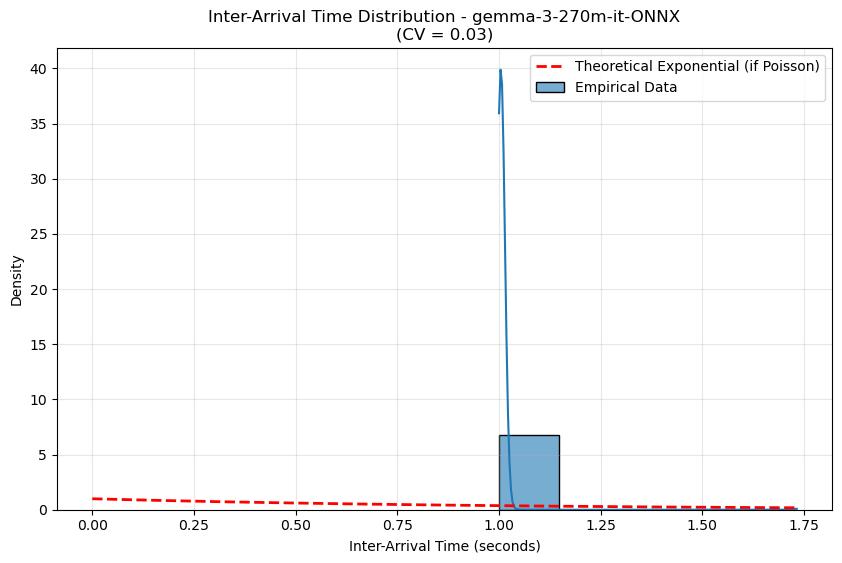

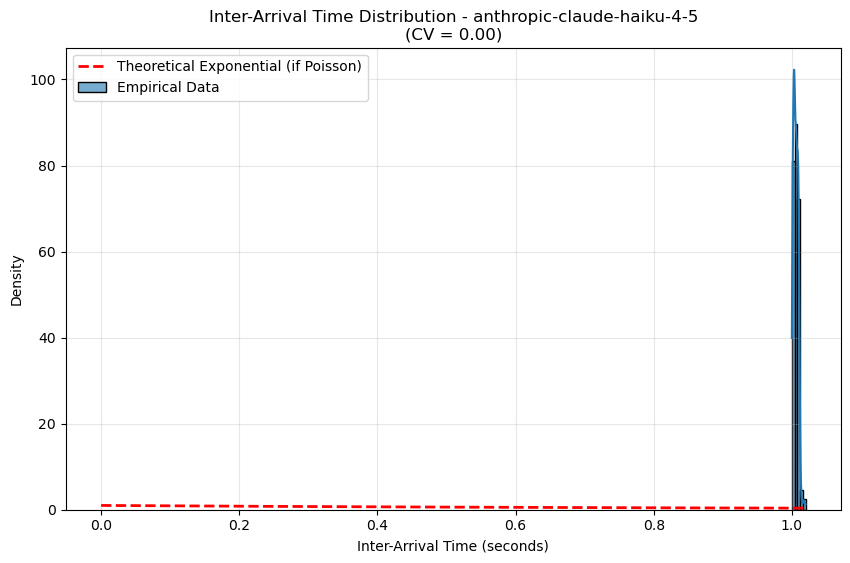

In [6]:
plot_inter_arrival_distribution(df_device_ex, name_device)
plot_inter_arrival_distribution(df_cloud_ex, name_cloud)

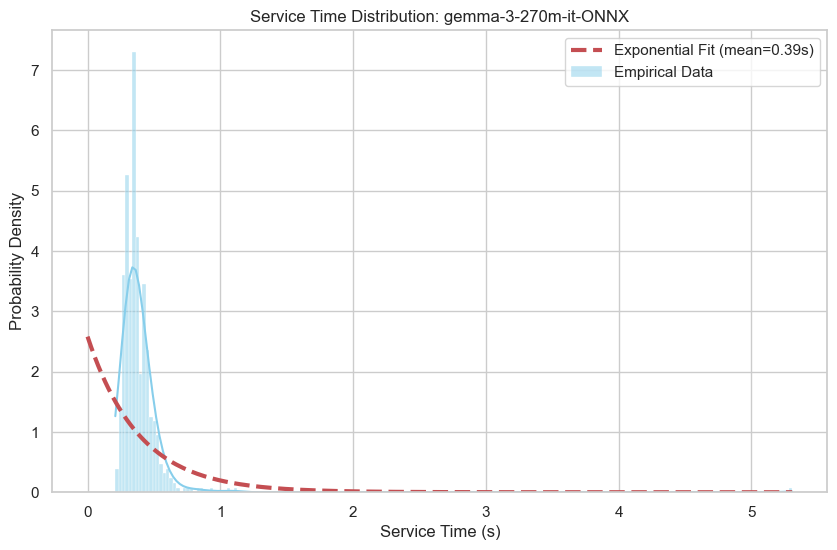

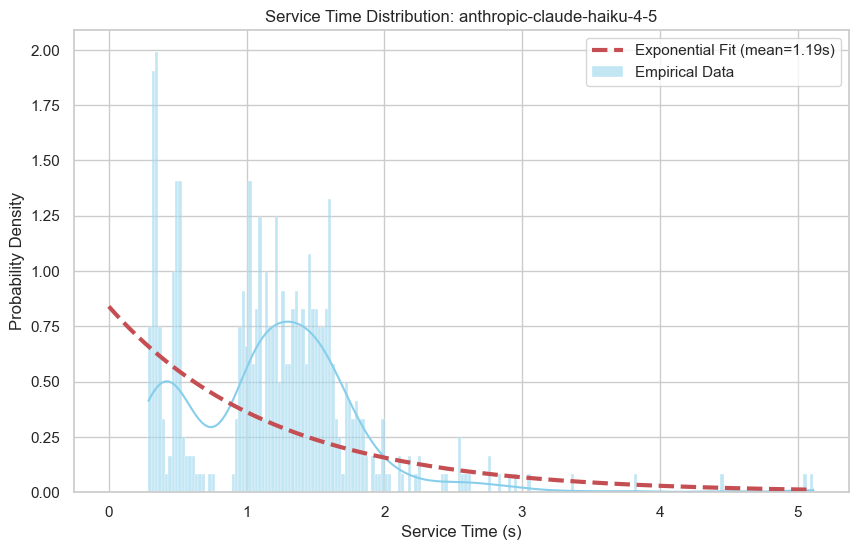

In [7]:
plot_service_time_distribution(df_device_ex, name_device)
plot_service_time_distribution(df_cloud_ex, name_cloud)

We can see that the interarrival times are roughly deterministic. This matches our expectations, as we did the experiments with 1 request per second. The service time distribution plots show that the empirical service times are not clearly exponential, with different shapes and variances for device and cloud. Therefore, for analysis, we model our cloud and on-device systems as **G/G/1** queues (General Arrival, General Service).

Since there is no exact closed-form solution for the mean waiting time in a G/G/1 queue, we use **Kingman's Approximation** (see lecture/literature). The expected waiting time $E[T_Q]$ is approximated as:

$$
E[T_Q] \approx \frac{\rho}{1-\rho} \cdot \frac{c_a^2 + c_s^2}{2} \cdot E[S]
$$

Where:
- $\rho = \lambda E[S]$ is the utilization.
- $E[S]$ is the mean service time.
- $c_a$ is the coefficient of variation of inter-arrival times ($c_a = \sigma_a / \mu_a$).
- $c_s$ is the coefficient of variation of service times ($c_s = \sigma_s / \mu_s$).

This formula generalizes the queueing behavior:
1.  **For our Experiment (G/G/1):** Since arrivals are deterministic, $c_a \approx 0$. The waiting time is driven purely by the service variability ($c_s^2$).
2.  **For M/G/1 (Theoretical):** If we assume random Poisson arrivals, $c_a = 1$. In this case, Kingman's formula simplifies back to the Pollaczek–Khinchine formula.

Using this approximation, we can analytically compute the expected mean response time for both our specific experiment ($c_a=0$) and for a hypothetical real-world scenario with random user arrivals ($c_a=1$).

G/G/1 Analysis | Lambda: 0.9952 | Ca: 0.0 (0=Det, 1=Exp)


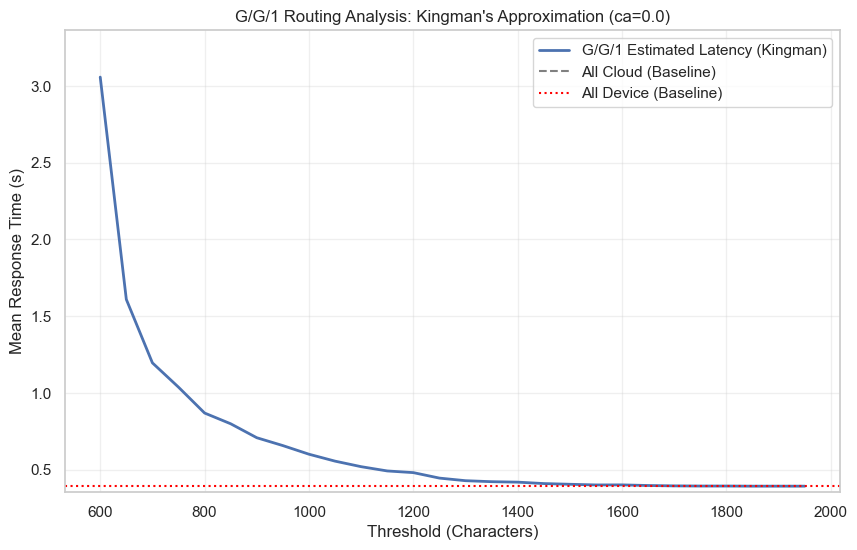

In [8]:
from utils import *

# --- Run Analysis ---
thresholds = range(0, 2000, 50)
# ca=0.0 models your deterministic experiment (D/G/1)
gg1_results = analyze_routing_gg1(df_device_ex, df_cloud_ex, thresholds, ca=0.0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='G/G/1 Estimated Latency (Kingman)', linewidth=2)
# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')
plt.axhline(y=gg1_results.iloc[-1]['avg_latency'], color='red', linestyle=':', label='All Device (Baseline)')

finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max() * 1.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min() * 0.9) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('G/G/1 Routing Analysis: Kingman\'s Approximation (ca=0.0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**how to interpret the analyis plot:**
- X-Axis is the Threshold we set for the routing policy. Any prompt with less characters than T is sent to local device, anything longer goes to the cloud. 
- Y-Axis is the Mean Response Time $E[R]$ for the combined system (device and cloud). It's the weighted weighted average time of requests served by device and cloud.
- The optimal Threshold is the minimum of the curve

**To validate the analytical G/G/1 setup (Kingman's approximation), we build a discrete‑event simulation.** We run two variations: one with **Deterministic arrivals** (matching our experiment, $c_a=0$) and one with **Poisson arrivals** (matching theoretical random traffic, $c_a=1$). For each arrival, we apply the routing rule (if size $\le T$ route to device, otherwise to cloud) and simulate the two FCFS queues using empirically sampled service times. For each threshold $T$, we estimate the average response time over many simulated jobs (`num_jobs`) and compare it to the analytical curves. This verifies that the approximation holds for both our specific experimental conditions and general random workloads.

Simulation Lambda: 0.9952 req/s | Ca: 0.0 | Simulating 20000 jobs...
Simulation Lambda: 0.9952 req/s | Ca: 1.0 | Simulating 20000 jobs...


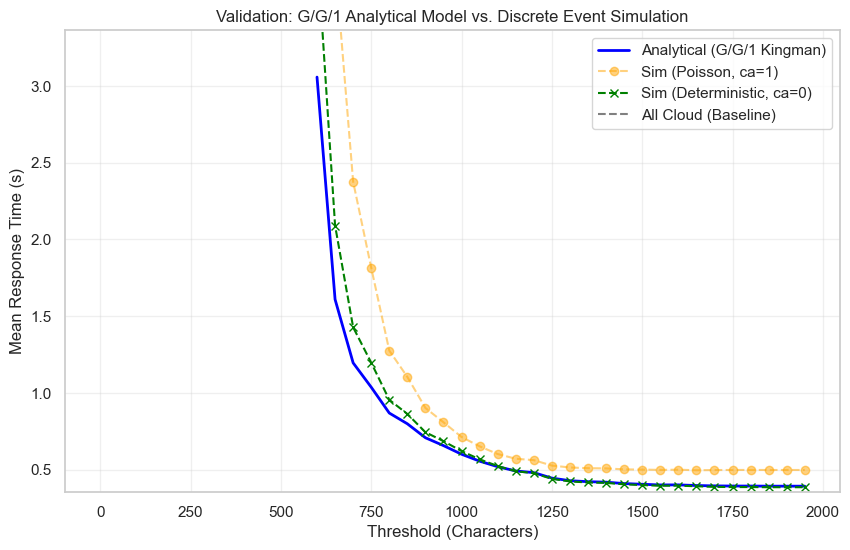

In [9]:
from utils import *

# --- Run Simulation ---
# Use fewer thresholds or jobs if it's too slow
sim_thresholds = range(0, 2000, 50) 

# Calculate Lambda once
lambda_sim = calculate_system_arrival_rate(df_device_ex, df_cloud_ex)

# Run Simulation with Deterministic Arrivals (ca=0.0)
sim_results_det = simulate_routing_validation(df_device_ex, df_cloud_ex, sim_thresholds, lambda_sim, num_jobs=20000, ca=0.0)

# Run Simulation with Poisson Arrivals (ca=1.0)
sim_results_poisson = simulate_routing_validation(df_device_ex, df_cloud_ex, sim_thresholds, lambda_sim, num_jobs=20000, ca=1.0)

# --- Plot Comparison ---
plt.figure(figsize=(10, 6))
# Note: Using gg1_results from the previous cell (Analytical Model)
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='Analytical (G/G/1 Kingman)', linewidth=2, color='blue')
plt.plot(sim_results_poisson['threshold'], sim_results_poisson['sim_latency'], 'o--', label='Sim (Poisson, ca=1)', color='orange', alpha=0.5)
plt.plot(sim_results_det['threshold'], sim_results_det['sim_latency'], 'x--', label='Sim (Deterministic, ca=0)', color='green')

# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')

# Dynamic Limits
finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max() * 1.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min() * 0.9) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('Validation: G/G/1 Analytical Model vs. Discrete Event Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The discrete-event simulation shows slightly lower latency than the Kingman approximation. This is expected, as Kingman's formula is an upper-bound approximation that tends to overestimate waiting times for deterministic arrivals at non-saturated utilization levels.


Now we want to look at a fully simulated version. Here we don't sample arrival- and inference time from our experiments, but we generate them artificially. Earlier we identified a linear relationship between input size and inference time, we will use this to generate accurate distributions to sample pairs of input sizes and inference times.

--- gemma-3-270m-it-ONNX ---
Slope: 0.000508 s/char
Intercept: -0.051748 s
R-squared: 0.4969


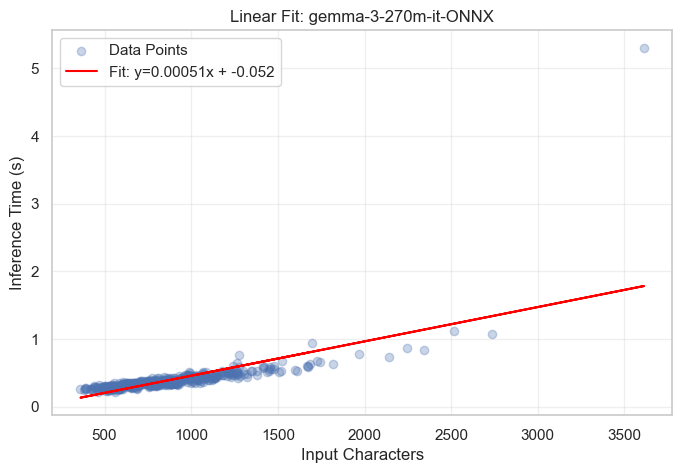

--- anthropic-claude-haiku-4-5 ---
Slope: 0.000092 s/char
Intercept: 1.111050 s
R-squared: 0.0024


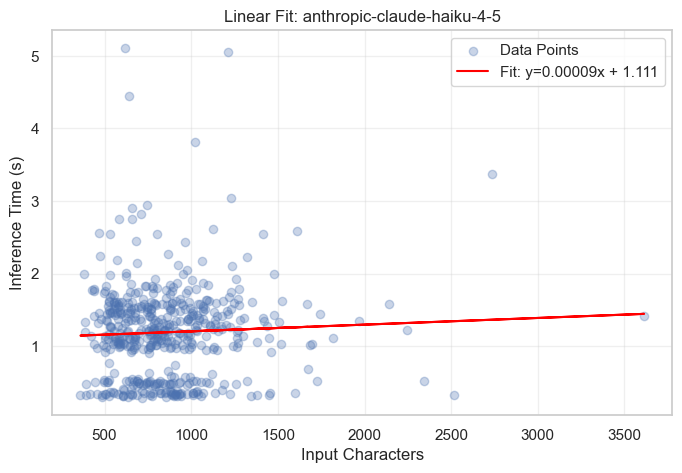


Simulation Params -> Char: (864.7, 340.3)


In [10]:
# Get parameters for Device
slope_dev, int_dev = estimate_linear_relationship(df_device_ex, name_device)

# Get parameters for Cloud
slope_cloud, int_cloud = estimate_linear_relationship(df_cloud_ex, name_cloud)

# Get parameters for Input Character Distribution
char_mean = df_device_ex['number_of_characters'].mean()
char_std = df_device_ex['number_of_characters'].std()

print(f"\nSimulation Params -> Char: ({char_mean:.1f}, {char_std:.1f})")

We can now take the slope and intercept of the cloud and on-device models and use them to generate sample jobs for our simulation. We will generate Gaussian distributed input sizes and calculate the corresponding inference times using the linear models.

0.9951615246670688


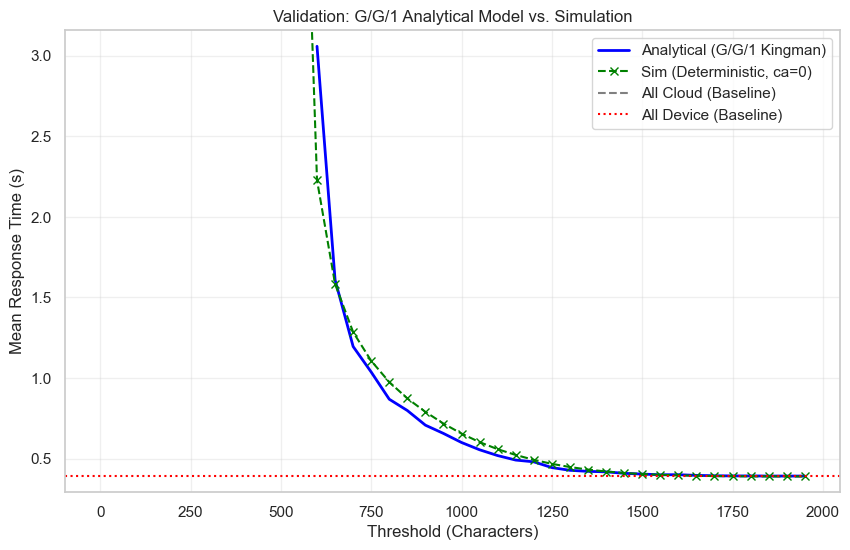

In [11]:
from utils import *

# --- Run Simulation ---
# Use fewer thresholds or jobs if it's too slow
sim_thresholds = range(0, 2000, 50) 

# Calculate Lambda once
lambda_sim = calculate_system_arrival_rate(df_device_ex, df_cloud_ex)
print(lambda_sim)

# Run Simulation with Deterministic Arrivals (ca=0.0)
sim_results_det = simulate_routing_synthetic(sim_thresholds, lambda_sim, num_jobs=100000, ca=0.0, char_params=(char_mean, char_std), dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

# Run Simulation with Poisson Arrivals (ca=1.0)
sim_results_poisson = simulate_routing_synthetic(sim_thresholds, lambda_sim, num_jobs=10000, ca=1.0, char_params=(char_mean, char_std), dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))

# --- Plot Comparison ---
plt.figure(figsize=(10, 6))
# Note: Using gg1_results from the previous cell (Analytical Model)
plt.plot(gg1_results['threshold'], gg1_results['avg_latency'], label='Analytical (G/G/1 Kingman)', linewidth=2, color='blue')
#plt.plot(sim_results_poisson['threshold'], sim_results_poisson['sim_latency'], 'o--', label='Sim (Poisson, ca=1)', color='orange', alpha=0.5)
plt.plot(sim_results_det['threshold'], sim_results_det['sim_latency'], 'x--', label='Sim (Deterministic, ca=0)', color='green')

# Baseline
plt.axhline(y=gg1_results.iloc[0]['avg_latency'], color='gray', linestyle='--', label='All Cloud (Baseline)')
plt.axhline(y=gg1_results.iloc[-1]['avg_latency'], color='red', linestyle=':', label='All Device (Baseline)')

# Dynamic Limits
finite_vals = gg1_results[gg1_results['avg_latency'] != float('inf')]['avg_latency']
upper_lim = finite_vals.max()+0.1 if not pd.isna(finite_vals.max()) else 2.0
lower_lim = max(0, finite_vals.min()-0.1) if not pd.isna(finite_vals.min()) else 0
plt.ylim(lower_lim, upper_lim)

plt.xlabel('Threshold (Characters)')
plt.ylabel('Mean Response Time (s)')
plt.title('Validation: G/G/1 Analytical Model vs. Simulation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- Analyzing: On-Device Model (gemma-3-270m-it-ONNX) ---
Mean Service Time (E[S]): 0.3874 s
Service Rate (μ): 2.58 req/s
Service Time CoV (cs): 0.63

--- Analyzing: Cloud Model (anthropic-claude-haiku-4-5) ---
Mean Service Time (E[S]): 1.1905 s
Service Rate (μ): 0.84 req/s
Service Time CoV (cs): 0.54



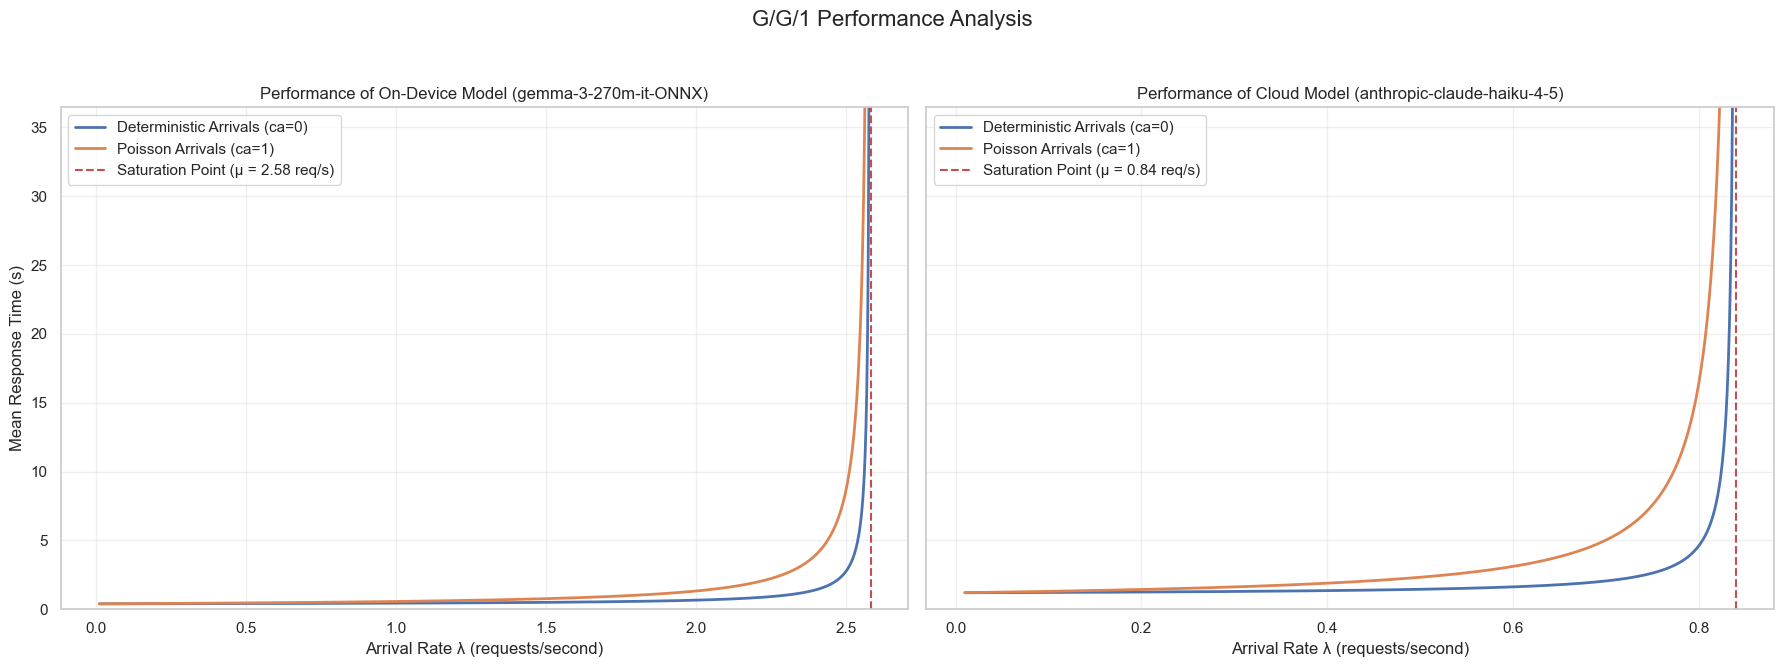

In [12]:
from utils import *
systems_to_analyze = [
    ("On-Device Model (" + name_device + ")", df_device_ex),
    ("Cloud Model (" + name_cloud + ")", df_cloud_ex)
]
plot_system_performance(systems_to_analyze)

We have successfully created a model where we can specify the relationship between input size and inference time for two G/G/1 systems, connected by a threshold-based scheduling policy. This allows us to simulate and optimize the system under various theoretical workloads (deterministic or poisson arrival) and hardware configurations.

## Deriving an input size based policy (Stateless Threshold Policy)

--- Running simulations for Deterministic Arrivals (ca=0.0) ---
  -> Simulating λ = 0.5 req/s
--- Running simulations for Poisson Arrivals (ca=1.0) ---
  -> Simulating λ = 0.5 req/s


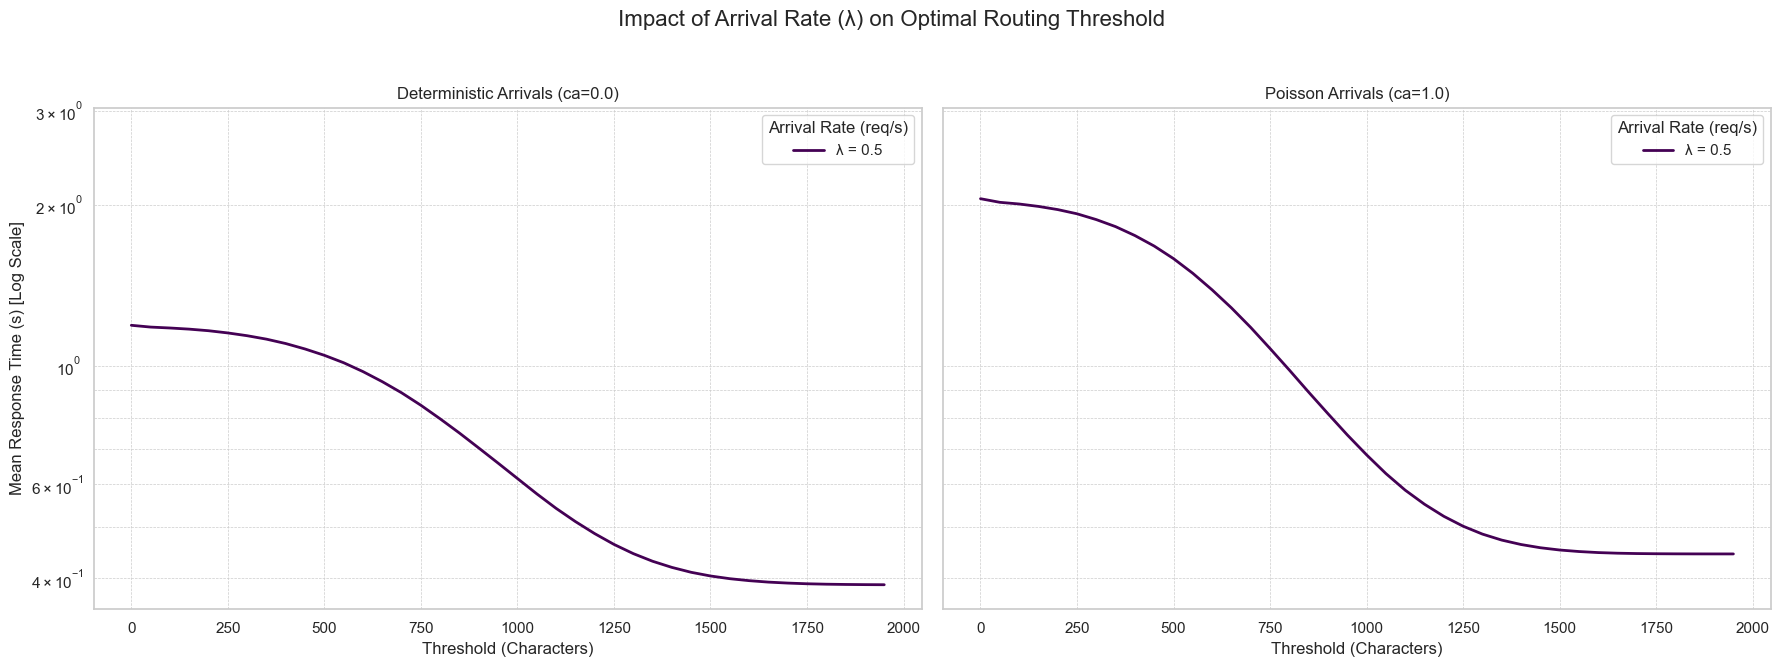

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
# Define a range of arrival rates to test
#test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4.0, 4.5]
test_lambdas = [0.5]
# Define the arrival scenarios to plot
scenarios = {
    "Deterministic Arrivals (ca=0.0)": 0.0,
    "Poisson Arrivals (ca=1.0)": 1.0
}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
fig.suptitle('Impact of Arrival Rate (λ) on Optimal Routing Threshold', fontsize=16)

colors = plt.cm.viridis(np.linspace(0, 1, len(test_lambdas)))
all_finite_latencies = []

# --- Loop through scenarios (Deterministic, Poisson) ---
for i, (title, ca_val) in enumerate(scenarios.items()):
    ax = axes[i]
    print(f"--- Running simulations for {title} ---")

    # --- Loop through different arrival rates (lambda) ---
    for j, lam in enumerate(test_lambdas):
        print(f"  -> Simulating λ = {lam:.1f} req/s")
        
        # Run synthetic simulation for the current scenario and lambda
        sim_res = simulate_routing_synthetic(
            thresholds, 
            lam, 
            num_jobs=200000,  # Reduced jobs slightly for faster plotting
            ca=ca_val,
            char_params=(char_mean, char_std), 
            dev_model=(slope_dev, int_dev), 
            cloud_model=(slope_cloud, int_cloud)
        )
        
        # Plot the curve on the correct subplot
        ax.plot(sim_res['threshold'], sim_res['sim_latency'], 
                 label=f'λ = {lam:.1f}', color=colors[j], linewidth=2)
        
        # Collect finite values for auto-scaling the y-axis
        finite_vals = sim_res[sim_res['sim_latency'] != float('inf')]['sim_latency']
        all_finite_latencies.extend(finite_vals.dropna().tolist())

    # --- Configure subplot ---
    ax.set_xlabel('Threshold (Characters)')
    ax.set_title(title)
    ax.legend(title="Arrival Rate (req/s)")
    ax.grid(True, which="both", linestyle='--', linewidth=0.5) # Grid for major and minor ticks
    ax.set_yscale('log') # Set y-axis to log scale

# --- Final plot configuration ---
axes[0].set_ylabel('Mean Response Time (s) [Log Scale]')

# Set reasonable Y-limits across both plots to ignore unstable queues
if all_finite_latencies:
    # Filter out zero or negative values before calculating min for log scale
    positive_latencies = [l for l in all_finite_latencies if l > 0]
    if positive_latencies:
        upper_lim = np.percentile(positive_latencies, 99) * 1.5 # Use percentile for robustness
        lower_lim = min(positive_latencies) * 0.9
        plt.ylim(lower_lim, upper_lim)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Stateful JSEQ Policy to keep track of queues
the scheduler is effectively asking: "Including the current backlog, which server will finish this specific job faster?" This is the core principle of the "Join the Shortest Expected Queue" (JSEQ) policy

--- Running simulations for different arrival rates ---

>>> Simulating for λ = 0.20 req/s...
  Optimal stateless T for λ=0.20 is 2150.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4082s
  - Always Cloud (anthropic-claude-haiku-4-5): 1.4046s
  - Stateless Threshold : 0.4082s
  - Stateful JSEQ       : 0.4079s

>>> Simulating for λ = 0.40 req/s...
  Optimal stateless T for λ=0.40 is 2150.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4464s
  - Always Cloud (anthropic-claude-haiku-4-5): 1.8060s
  - Stateless Threshold : 0.4464s
  - Stateful JSEQ       : 0.4425s

>>> Simulating for λ = 0.60 req/s...
  Optimal stateless T for λ=0.60 is 1900.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4677s
  - Always Cloud (anthropic-claude-haiku-4-5): 2.7044s
  - Stateless Threshold : 0.4682s
  - Stateful JSEQ       : 0.4627s

>>> Simulating for λ = 0.80 req/s...
  Optimal stateless T for λ=0.80 is 1850.0 chars.
  - Always Device (gemma-3-270m-it-ONNX): 0.4932s
  - Always Cloud (anthr

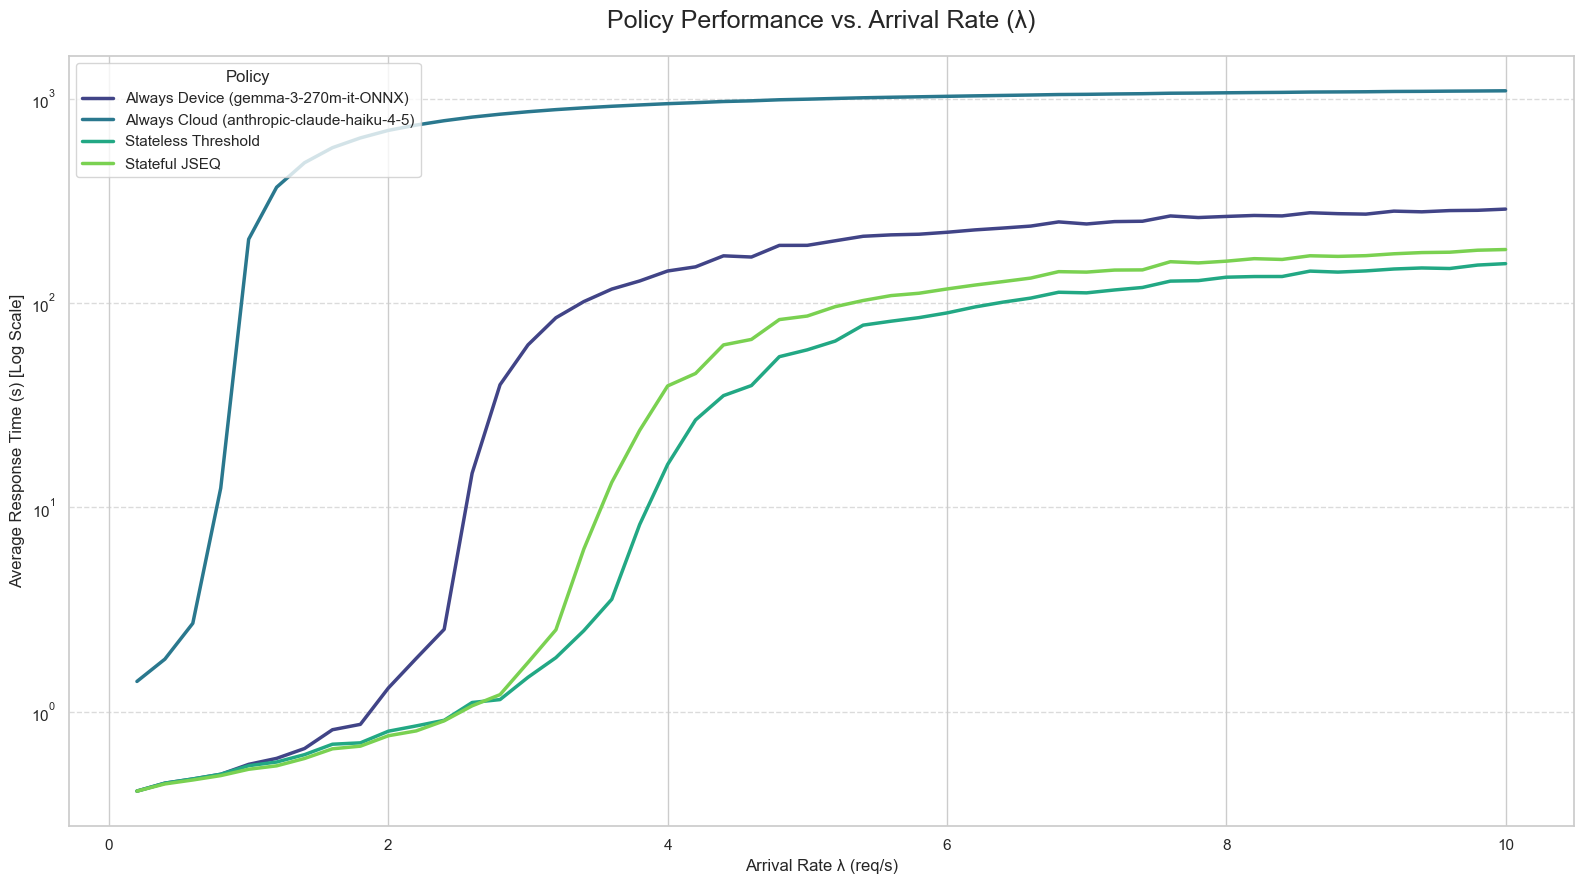

lambda,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,...,8.2,8.4,8.6,8.8,9.0,9.2,9.4,9.6,9.8,10.0
policy,,,,,,,,,,,,,,,,,,,,,
Always Device (gemma-3-270m-it-ONNX),0.408192,0.446386,0.467689,0.493204,0.551756,0.590129,0.659477,0.815081,0.865988,1.303616,...,268.013740,266.659682,276.357921,273.472914,272.071723,281.418777,279.242937,283.201667,284.089094,287.926485
Always Cloud (anthropic-claude-haiku-4-5),1.404579,1.805953,2.704356,12.414469,205.032165,368.250970,485.631590,575.306051,642.235901,699.185895,...,1070.840432,1072.965975,1077.005549,1078.570201,1080.364987,1084.015665,1085.489832,1087.980489,1089.858494,1092.226273
Stateless Threshold,0.408192,0.446384,0.468179,0.493637,0.543407,0.566413,0.615508,0.692227,0.703125,0.801533,...,134.656519,134.715217,143.146185,141.571386,143.487522,146.598294,148.321060,147.406436,153.248776,155.735303
Stateful JSEQ,0.407917,0.442484,0.462697,0.486127,0.522067,0.542601,0.589612,0.657435,0.677355,0.761654,...,164.700364,163.260446,170.159917,168.977769,170.376305,174.023915,176.400251,177.135140,181.176239,182.569779


In [20]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from utils import *



# --- 1. SETUP ---
# Define the arrival rates (lambda) you want to test
test_lambdas = np.linspace(0.2, 10, 50)
#test_lambdas = [1,2,3,4,5,6,7,8,9] 
num_sim_requests = 2000 # Use a reasonable number of requests for stable results
policies_to_test = ['Always Device ('+name_device+')', 'Always Cloud ('+name_cloud+')', 'Stateless Threshold', 'Stateful JSEQ']
all_results = []

# --- 2. DEFINE A GENERIC SIMULATION RUNNER ---
def run_policy_simulation(scheduler, requests):
    """Runs a simulation for a given scheduler and request stream."""
    total_latency = 0.0
    # Reset scheduler state before each run
    scheduler.reset()
    for req in requests:
        _, _, finish_time = scheduler.decide_at_time(req['size'], req['arrival_time'])
        response_time = finish_time - req['arrival_time']
        total_latency += response_time
    
    avg_latency = total_latency / len(requests) if requests else 0.0
    # Add a check for instability
    if avg_latency > 1000.0: # If average latency exceeds 1000s, consider it unstable
        return avg_latency # Return NaN for unstable results to make plotting cleaner
    return avg_latency

# --- 3. MAIN SIMULATION LOOP ---
print("--- Running simulations for different arrival rates ---")

for lam in test_lambdas:
    print(f"\n>>> Simulating for λ = {lam:.2f} req/s...")
    
    # --- a) Generate a consistent request stream for this lambda ---
    request_stream = []
    current_time = 0.0
    for i in range(num_sim_requests):
        # Generate Poisson arrivals for the given lambda
        inter_arrival_time = random.expovariate(lam)
        current_time += inter_arrival_time
        # Generate a synthetic input size
        input_len = int(max(1, np.random.normal(char_mean, char_std)))
        request_stream.append({'id': i, 'arrival_time': current_time, 'size': input_len})

    # --- b) Find the optimal threshold for the Stateless policy AT THIS LAMBDA ---
    thresholds_scan = range(0, 2500, 50) # Scan thresholds to find the best one
    sim_results_for_T = simulate_routing_synthetic(
        thresholds_scan, lam, num_jobs=2000, ca=1.0, 
        char_params=(char_mean, char_std), 
        dev_model=(slope_dev, int_dev), 
        cloud_model=(slope_cloud, int_cloud)
    )
    optimal_T_stateless = sim_results_for_T.loc[sim_results_for_T['sim_latency'].idxmin()]['threshold']
    print(f"  Optimal stateless T for λ={lam:.2f} is {optimal_T_stateless} chars.")

    # --- c) Initialize all schedulers for this run ---
    schedulers = {}
    for policy_name in policies_to_test:
        if 'Always Device' in policy_name:
            schedulers[policy_name] = StatefulScheduler(
                dev_model=(slope_dev, int_dev), 
                cloud_model=(slope_cloud, int_cloud), 
                force_policy='device'
            )
        elif 'Always Cloud' in policy_name:
            schedulers[policy_name] = StatefulScheduler(
                dev_model=(slope_dev, int_dev), 
                cloud_model=(slope_cloud, int_cloud), 
                force_policy='cloud'
            )
        else: # For 'Stateful JSEQ' and 'Stateless Threshold'
            schedulers[policy_name] = StatefulScheduler(
                dev_model=(slope_dev, int_dev), 
                cloud_model=(slope_cloud, int_cloud)
            )
    
    
    # --- FIX for Stateless Threshold Scheduler ---
    # Define a function that correctly captures the scheduler instance and threshold
    def create_stateless_decision_function(scheduler_instance, threshold):
        def decision_function(size, time):
            if size <= threshold:
                return scheduler_instance.route_to_device(size, time)
            else:
                return scheduler_instance.route_to_cloud(size, time)
        return decision_function

    # Assign the correctly scoped function to the scheduler's decide_at_time method
    schedulers['Stateless Threshold'].decide_at_time = create_stateless_decision_function(
        schedulers['Stateless Threshold'],
        optimal_T_stateless
    )


    # --- d) Run simulation for each policy ---
    for policy_name in policies_to_test:
        scheduler = schedulers[policy_name]
        avg_latency = run_policy_simulation(scheduler, request_stream)
        all_results.append({'lambda': lam, 'policy': policy_name, 'latency': avg_latency})
        print(f"  - {policy_name:<20}: {avg_latency:.4f}s")

# --- 4. PREPARE DATA FOR PLOTTING ---
results_df = pd.DataFrame(all_results)
# No pivot needed for seaborn, it prefers long-form data.

# --- 5. CREATE LINE PLOT WITH SEABORN ---
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(16, 9))

# Use a lineplot to show the trend of latency vs. lambda for each policy
sns.lineplot(
    data=results_df,
    x='lambda',
    y='latency',
    hue='policy',
    hue_order=policies_to_test, # Ensure the policy order is correct in the legend
    style='policy', # Use different line styles for each policy
    markers=False,   # Add markers to each data point
    dashes=False,
    ax=ax,
    palette='viridis', # Use a nice color palette
    linewidth=2.5
)

# --- 6. FORMATTING ---
ax.set_title('Policy Performance vs. Arrival Rate (λ)', fontsize=18, pad=20)
ax.set_ylabel('Average Response Time (s) [Log Scale]', fontsize=12)
ax.set_xlabel('Arrival Rate λ (req/s)', fontsize=12)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.set_yscale('log') # Set the y-axis to a logarithmic scale

# Customize grid and legend
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.legend(title="Policy", loc='upper left', ncol=1)

plt.tight_layout() # Adjust layout
plt.show()

display(results_df.pivot(index='policy', columns='lambda', values='latency').reindex(policies_to_test))

--- Running simulations for different arrival rates ---

>>> Simulating for λ = 0.20 req/s...
  Optimal stateless T for λ=0.20 is 1900 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.40 req/s...
  Optimal stateless T for λ=0.40 is 2000 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.60 req/s...
  Optimal stateless T for λ=0.60 is 1900 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 0.80 req/s...
  Optimal stateless T for λ=0.80 is 1800 chars.
  - Always Device       : Done.
  - Always Cloud        : Done.
  - Stateless Threshold : Done.
  - Stateful JSEQ       : Done.

>>> Simulating for λ = 1.00 req/s...
  Optimal stateless T for λ=1.00 is 1500 chars.
  

,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.0208,0.3852,0.00,0.00
0.400000,0.0432,0.3841,0.02,0.00
0.600000,0.0757,0.3903,0.04,0.00
0.800000,0.1105,0.3873,0.09,0.00
1.000000,0.1384,0.3863,0.14,0.00
1.200000,0.2140,0.3888,0.27,0.00
1.400000,0.2882,0.3895,0.40,0.00
1.600000,0.3865,0.3895,0.62,0.00
1.800000,0.4996,0.3880,0.89,0.00




--- Results for: Always Cloud ---


,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.1874,1.1902,0.00,0.04
0.400000,0.5506,1.1899,0.00,0.23
0.600000,1.3934,1.1911,0.00,0.81
0.800000,17.3063,1.1905,0.00,13.98
1.000000,426.2535,1.1903,0.00,357.64
1.200000,968.7704,1.1908,0.00,813.35
1.400000,1170.8723,1.1909,0.00,982.99
1.600000,1406.9076,1.1909,0.00,1181.29
1.800000,1573.1228,1.1907,0.00,1320.75




--- Results for: Stateless Threshold ---


,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.0207,0.3855,0.00,0.00
0.400000,0.0432,0.3842,0.02,0.00
0.600000,0.0757,0.3907,0.04,0.00
0.800000,0.1092,0.3884,0.09,0.00
1.000000,0.1174,0.4007,0.11,0.00
1.200000,0.1581,0.4201,0.19,0.00
1.400000,0.1746,0.4453,0.23,0.02
1.600000,0.2083,0.4452,0.31,0.02
1.800000,0.2236,0.4845,0.28,0.12




--- Results for: Stateful JSEQ ---


,Avg Wait Time (s),Avg Inference Time (s),Avg Device Queue Length,Avg Cloud Queue Length
Lambda,,,,
0.200000,0.0195,0.3861,0.00,0.00
0.400000,0.0389,0.3871,0.02,0.00
0.600000,0.0630,0.3965,0.04,0.00
0.800000,0.0875,0.3974,0.07,0.00
1.000000,0.1066,0.4006,0.10,0.00
1.200000,0.1422,0.4114,0.18,0.00
1.400000,0.1733,0.4205,0.24,0.00
1.600000,0.2131,0.4263,0.34,0.00
1.800000,0.2382,0.4344,0.42,0.01


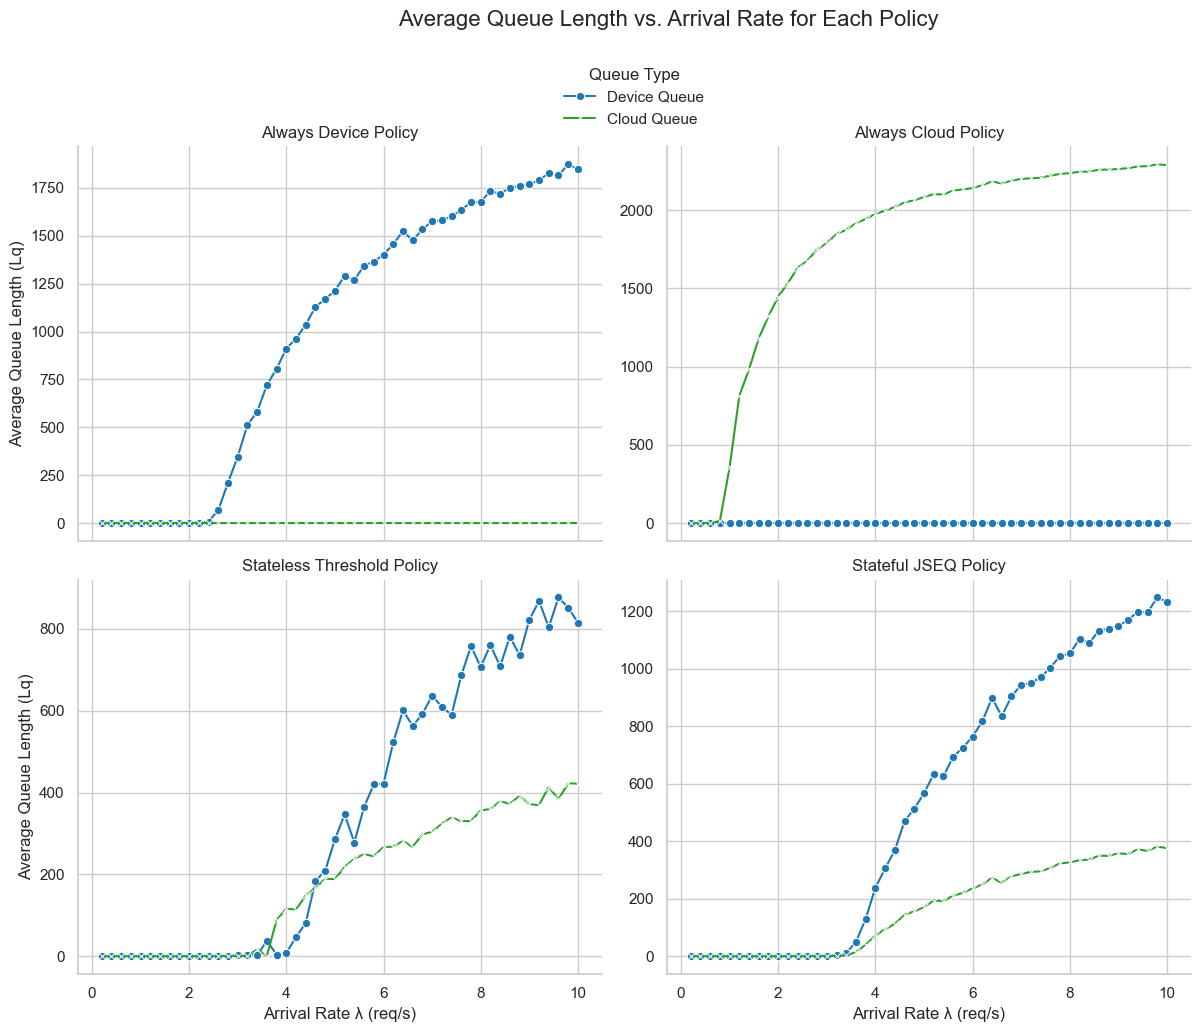

In [ ]:
# --- 1. SETUP ---
#test_lambdas = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9] 
num_sim_requests = 5000
policies_to_test = ['Always Device', 'Always Cloud', 'Stateless Threshold', 'Stateful JSEQ']
detailed_results = []

# --- 2. MODIFIED SIMULATION RUNNER TO COLLECT DETAILED STATS ---
def run_detailed_policy_simulation(policy_name, scheduler, requests, stateless_threshold=None):
    """Runs a simulation and returns detailed statistics for each request."""
    request_stats = []
    scheduler.reset()

    # For the 'Stateless Threshold' policy, we must simulate it statelessly.
    # This means using a new, clean scheduler for each decision to prevent state carry-over.
    if policy_name == 'Stateless Threshold':
        # This temporary scheduler will be used to process all requests for this run.
        # Its internal state will be updated correctly for each request.
        temp_stateless_scheduler = StatefulScheduler(dev_model=scheduler.dev_model, cloud_model=scheduler.cloud_model)
        for req in requests:
            if req['size'] <= stateless_threshold:
                decision, start_time, finish_time = temp_stateless_scheduler.route_to_device(req['size'], req['arrival_time'])
            else:
                decision, start_time, finish_time = temp_stateless_scheduler.route_to_cloud(req['size'], req['arrival_time'])
            
            wait_time = start_time - req['arrival_time']
            service_time = finish_time - start_time
            request_stats.append({'wait_time': wait_time, 'service_time': service_time, 'decision': decision})
    else:
        # For all other stateful policies, the original logic is correct.
        for req in requests:
            decision, start_time, finish_time = scheduler.decide_at_time(req['size'], req['arrival_time'])
            wait_time = start_time - req['arrival_time']
            service_time = finish_time - start_time
            request_stats.append({'wait_time': wait_time, 'service_time': service_time, 'decision': decision})
            
    return request_stats

# --- 3. MAIN SIMULATION LOOP ---
print("--- Running simulations for different arrival rates ---")

for lam in test_lambdas:
    print(f"\n>>> Simulating for λ = {lam:.2f} req/s...")
    
    # --- a) Generate a consistent request stream for this lambda ---
    request_stream = []
    current_time = 0.0
    for i in range(num_sim_requests):
        inter_arrival_time = random.expovariate(lam)
        current_time += inter_arrival_time
        input_len = int(max(1, np.random.normal(char_mean, char_std)))
        request_stream.append({'id': i, 'arrival_time': current_time, 'size': input_len})

    # --- b) Find the optimal threshold for the Stateless policy AT THIS LAMBDA ---
    thresholds_scan = range(0, 2500, 100)
    best_latency_for_T = float('inf')
    optimal_T_stateless = -1
    
    # This sub-simulation is to find the best T. It needs its own request stream.
    temp_request_stream = []
    temp_current_time = 0.0
    for i in range(2000): 
        inter_arrival_time = random.expovariate(lam)
        temp_current_time += inter_arrival_time
        input_len = int(max(1, np.random.normal(char_mean, char_std)))
        temp_request_stream.append({'arrival_time': temp_current_time, 'size': input_len})

    for T in thresholds_scan:
        # Create a completely new scheduler for each threshold test to ensure a clean state.
        temp_scheduler = StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))
        total_latency = 0.0
        for req in temp_request_stream:
            if req['size'] <= T:
                _, _, finish_time = temp_scheduler.route_to_device(req['size'], req['arrival_time'])
            else:
                _, _, finish_time = temp_scheduler.route_to_cloud(req['size'], req['arrival_time'])
            total_latency += (finish_time - req['arrival_time'])
        avg_latency = total_latency / len(temp_request_stream)
        if avg_latency < best_latency_for_T:
            best_latency_for_T = avg_latency
            optimal_T_stateless = T
    print(f"  Optimal stateless T for λ={lam:.2f} is {optimal_T_stateless} chars.")

    # --- c) Initialize all schedulers ---
    schedulers = {
        'Stateful JSEQ': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud)),
        'Always Cloud': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='cloud'),
        'Always Device': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud), force_policy='device'),
        'Stateless Threshold': StatefulScheduler(dev_model=(slope_dev, int_dev), cloud_model=(slope_cloud, int_cloud))
    }
    # We no longer override decide_at_time. We pass the threshold to the runner.

    # --- d) Run simulation and process results for each policy ---
    for policy_name in policies_to_test:
        stats = run_detailed_policy_simulation(
            policy_name, 
            schedulers[policy_name], 
            request_stream, 
            stateless_threshold=optimal_T_stateless
        )
        df_stats = pd.DataFrame(stats)
        
        avg_wait_time = df_stats['wait_time'].mean()
        avg_service_time = df_stats['service_time'].mean()

        # This calculation of total_simulation_time is correct.
        df_stats['finish_time'] = df_stats['wait_time'] + df_stats['service_time'] + pd.Series([r['arrival_time'] for r in request_stream])
        total_simulation_time = df_stats['finish_time'].max()
        
        df_stats['decision_clean'] = df_stats['decision'].str.strip().str.lower()
        device_stats = df_stats[df_stats['decision_clean'] == 'device']
        cloud_stats = df_stats[df_stats['decision_clean'] == 'cloud']
        
        
        # This is the correct way to calculate effective arrival rate to each queue.
        lambda_device = len(device_stats) / total_simulation_time if total_simulation_time > 0 else 0
        lambda_cloud = len(cloud_stats) / total_simulation_time if total_simulation_time > 0 else 0
        
        # This is the correct way to calculate average wait time in each queue.
        avg_wait_device = device_stats['wait_time'].mean() if not device_stats.empty else 0
        avg_wait_cloud = cloud_stats['wait_time'].mean() if not cloud_stats.empty else 0

                # --- DEBUGGING BLOCK ---
        # Let's inspect the values for one specific case to see what's happening.
        if lam == 0.5 and policy_name == 'Stateless Threshold':
            print("\n--- DEBUGGING OUTPUT ---")
            print(f"Policy: {policy_name}, Lambda: {lam}")
            print("First 5 stats entries:")
            print(df_stats.head())
            print("\nBreakdown:")
            print(f"  Total Sim Time: {total_simulation_time:.2f}s")
            print(f"  Num Device Jobs: {len(device_stats)}, Num Cloud Jobs: {len(cloud_stats)}")
            print(f"  Lambda Device (eff): {lambda_device:.4f}, Lambda Cloud (eff): {lambda_cloud:.4f}")
            print(f"  Avg Wait Device: {avg_wait_device:.6f}, Avg Wait Cloud: {avg_wait_cloud:.6f}")
            print(f"  Calculated Device Q-Len: {lambda_device * avg_wait_device:.4f}")
            print(f"  Calculated Cloud Q-Len: {lambda_cloud * avg_wait_cloud:.4f}")
            print("--- END DEBUGGING ---\n")
        
        # This is the correct application of Little's Law: Lq = λq * Wq
        # If avg_wait_device is non-zero, this will produce a non-zero queue length.
        avg_q_len_device = lambda_device * avg_wait_device
        avg_q_len_cloud = lambda_cloud * avg_wait_cloud
        
        detailed_results.append({
            'Lambda': lam,
            'Policy': policy_name,
            'Avg Wait Time (s)': avg_wait_time,
            'Avg Inference Time (s)': avg_service_time,
            'Avg Device Queue Length': avg_q_len_device,
            'Avg Cloud Queue Length': avg_q_len_cloud
        })
        print(f"  - {policy_name:<20}: Done.")

# --- 4. DISPLAY RESULTS IN A TABLE ---
results_df = pd.DataFrame(detailed_results)

for policy in policies_to_test:
    print(f"\n\n--- Results for: {policy} ---")
    policy_df = results_df[results_df['Policy'] == policy].set_index('Lambda')
    display(policy_df[[
        'Avg Wait Time (s)', 
        'Avg Inference Time (s)', 
        'Avg Device Queue Length', 
        'Avg Cloud Queue Length'
    ]].style.format({
        'Avg Wait Time (s)': '{:.4f}',
        'Avg Inference Time (s)': '{:.4f}',
        'Avg Device Queue Length': '{:.2f}',
        'Avg Cloud Queue Length': '{:.2f}'
    }).background_gradient(
        cmap='viridis', 
        subset=['Avg Wait Time (s)', 'Avg Device Queue Length', 'Avg Cloud Queue Length']
    ))


# --- 5. PLOT QUEUE LENGTHS VS. ARRIVAL RATE ---
import seaborn as sns
sns.set_theme(style="whitegrid")

# Create a FacetGrid to make one subplot per policy
g = sns.FacetGrid(results_df, col="Policy", col_wrap=2, height=5, aspect=1.2, sharey=False)

# Map the line plots for device and cloud queue lengths
g.map_dataframe(sns.lineplot, x="Lambda", y="Avg Device Queue Length", color='#1f77b4', marker='o', label="Device Queue")
g.map_dataframe(sns.lineplot, x="Lambda", y="Avg Cloud Queue Length", color='#2ca02c', marker='x', label="Cloud Queue")

# Adjust titles and labels
g.set_axis_labels("Arrival Rate λ (req/s)", "Average Queue Length (Lq)")
g.set_titles(col_template="{col_name} Policy")

# Add and reposition the legend
g.add_legend(title="Queue Type")
sns.move_legend(g, "lower center", bbox_to_anchor=(0.475, 0.9))

# Add a main title for the entire figure
g.fig.suptitle('Average Queue Length vs. Arrival Rate for Each Policy', y=1.03, fontsize=16)

# Adjust layout to prevent title overlap and make space for the legend
plt.tight_layout(rect=[0, 0, 0.9, 0.97])
plt.show()